In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/Users/arimuraterutoshi/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# CSVデータの読み込み
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
# データの内容確認
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13606,-122.0,37.8,16.0,2498.0,330.0,1027.0,343.0,8.2,343.7
361,-116.9,32.8,16.0,5203.0,898.0,2515.0,862.0,4.1,174.4
5591,-118.2,33.8,39.0,2953.0,878.0,1379.0,785.0,2.1,180.4
6627,-118.3,34.0,40.0,2044.0,538.0,2150.0,524.0,2.1,94.8
10668,-120.6,35.1,14.0,6788.0,1216.0,2866.0,1036.0,3.4,280.2
...,...,...,...,...,...,...,...,...,...
16979,-124.2,40.8,37.0,1453.0,293.0,867.0,310.0,2.6,70.2
7630,-118.4,34.0,41.0,2369.0,544.0,1252.0,522.0,3.0,296.1
8156,-118.4,34.0,26.0,1706.0,516.0,894.0,435.0,3.2,372.7
13223,-121.9,37.3,26.0,3756.0,553.0,1408.0,535.0,5.6,320.0


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [5]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [6]:
my_feature

,total_rooms
13606,2498.0
361,5203.0
5591,2953.0
6627,2044.0
10668,6788.0
...,...
16979,1453.0
7630,2369.0
8156,1706.0
13223,3756.0


In [7]:
feature_columns

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [8]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

In [9]:
targets[0:5]

13606   343.7
361     174.4
5591    180.4
6627     94.8
10668   280.2
Name: median_house_value, dtype: float64

In [10]:
# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

In [11]:
# データをシャッフルした後一件のデータを取り出す(SGD)
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
# モデルの訓練(1エポック)
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [13]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions

<generator object Estimator.predict at 0x1281b1f68>

In [14]:
# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])
predictions

array([0.12490001, 0.26014996, 0.14764999, ..., 0.08530001, 0.18779999,
       0.06700002], dtype=float32)

In [15]:
# 教師データ、テストデータそれぞれで誤差を算出
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [16]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [17]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [18]:
sample = california_housing_dataframe.sample(n=300)

In [19]:
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# 訓練後のパラメータとバイアスを表示
print(weight)
print(bias)

[4.9999988e-05]
[3.448651e-08]


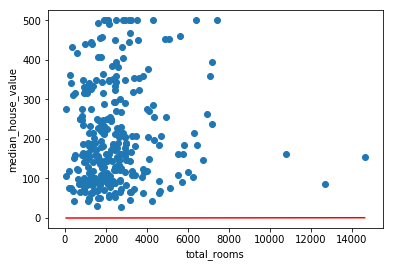

In [20]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()



# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率が小さすぎると一向に進まない

In [21]:
# モデルの訓練(1エポック)
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
# 教師データ、テストデータそれぞれで誤差を算出
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56308.998
Root Mean Squared Error (on training data): 237.295


period:0
Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417
period:1
Mean Squared Error (on training data): 56308.998
Root Mean Squared Error (on training data): 237.295
period:2
Mean Squared Error (on training data): 56251.030
Root Mean Squared Error (on training data): 237.173
period:3
Mean Squared Error (on training data): 56193.120
Root Mean Squared Error (on training data): 237.051
period:4
Mean Squared Error (on training data): 56135.268
Root Mean Squared Error (on training data): 236.929
period:5
Mean Squared Error (on training data): 56077.477
Root Mean Squared Error (on training data): 236.807
period:6
Mean Squared Error (on training data): 56019.743
Root Mean Squared Error (on training data): 236.685
period:7
Mean Squared Error (on training data): 55962.068
Root Mean Squared Error (on training data): 236.563
period:8
Mean Squared Error (on training data): 55904.451
Root Mean Squared Error (on training data): 236.441
period:9
M

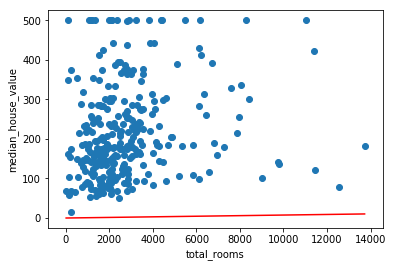

In [22]:
# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(15):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=100
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
sample = california_housing_dataframe.sample(n=300)
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率が小さすぎると一向に進まない

period:0
Mean Squared Error (on training data): 50907.119
Root Mean Squared Error (on training data): 225.626
period:1
Mean Squared Error (on training data): 46069.038
Root Mean Squared Error (on training data): 214.637
period:2
Mean Squared Error (on training data): 41794.753
Root Mean Squared Error (on training data): 204.438
period:3
Mean Squared Error (on training data): 38508.272
Root Mean Squared Error (on training data): 196.235
period:4
Mean Squared Error (on training data): 35655.969
Root Mean Squared Error (on training data): 188.828
period:5
Mean Squared Error (on training data): 33496.724
Root Mean Squared Error (on training data): 183.021
period:6
Mean Squared Error (on training data): 31462.313
Root Mean Squared Error (on training data): 177.376
period:7
Mean Squared Error (on training data): 30059.312
Root Mean Squared Error (on training data): 173.376
period:8
Mean Squared Error (on training data): 29079.225
Root Mean Squared Error (on training data): 170.526
period:9
M

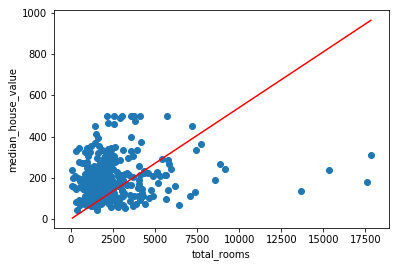

In [23]:
# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(15):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=100
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
sample = california_housing_dataframe.sample(n=300)
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率がちょうど良いと安定して進む

period:0
Mean Squared Error (on training data): 28154.888
Root Mean Squared Error (on training data): 167.794
period:1
Mean Squared Error (on training data): 30128.171
Root Mean Squared Error (on training data): 173.575
period:2
Mean Squared Error (on training data): 36539.191
Root Mean Squared Error (on training data): 191.152
period:3
Mean Squared Error (on training data): 39310.189
Root Mean Squared Error (on training data): 198.268
period:4
Mean Squared Error (on training data): 45979.302
Root Mean Squared Error (on training data): 214.428
period:5
Mean Squared Error (on training data): 42456.870
Root Mean Squared Error (on training data): 206.051
period:6
Mean Squared Error (on training data): 36537.827
Root Mean Squared Error (on training data): 191.149
period:7
Mean Squared Error (on training data): 40060.042
Root Mean Squared Error (on training data): 200.150
period:8
Mean Squared Error (on training data): 39308.631
Root Mean Squared Error (on training data): 198.264
period:9
M

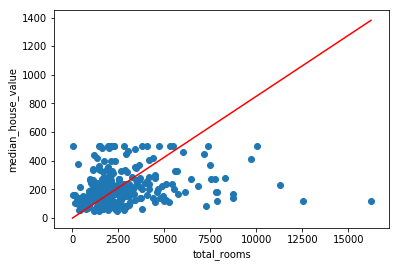

In [24]:
# optimizerはパラメータの更新に使う設定
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(15):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=100
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
sample = california_housing_dataframe.sample(n=300)
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率が大きすぎるとジグザグ進む

In [25]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
          to use as input feature.
    """
    # 10回学習する
    periods = 10
    steps_per_period = steps / periods
    
    # 説明変数初期化
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    # 目的変数
    targets = california_housing_dataframe[my_label]

    # 説明変数のカラム生成
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # 線形回帰用のモデルを生成
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
          feature_columns=feature_columns,
          optimizer=my_optimizer
    )

    # 描画用の設定初期化
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    # サンプルデータを300件表示させる
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    # ピリオド毎の学習結果のモデル描画用の色分けに使う
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # モデルを訓練
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # 訓練後に予測をして誤差を取得
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        # scikit-learnで平均二乗誤差を求めた後に平方根を取得
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Take a break and compute predictions.

        
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        # ピリオド毎で学習した結果のモデルを描画
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")
    plt.show()

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    plt.show()

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 195.69
  period 04 : 187.86
  period 05 : 180.80
  period 06 : 175.66
  period 07 : 171.74
  period 08 : 169.21
  period 09 : 167.62
Model training finished.


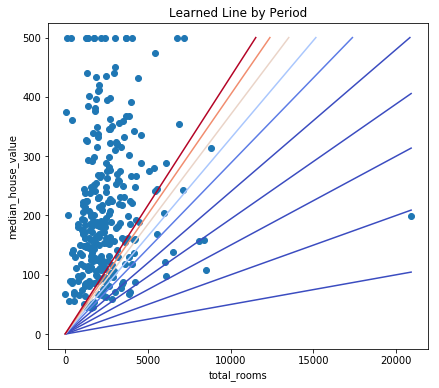

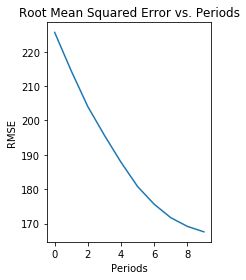

,predictions,targets
count,17000.0,17000.0
mean,114.7,207.3
std,94.6,116.0
min,0.1,15.0
25%,63.5,119.4
50%,92.3,180.4
75%,136.8,265.0
max,1646.5,500.0


Final RMSE (on training data): 167.62


In [26]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 204.86
  period 03 : 196.59
  period 04 : 189.39
  period 05 : 184.79
  period 06 : 180.51
  period 07 : 178.24
  period 08 : 176.63
  period 09 : 176.06
Model training finished.


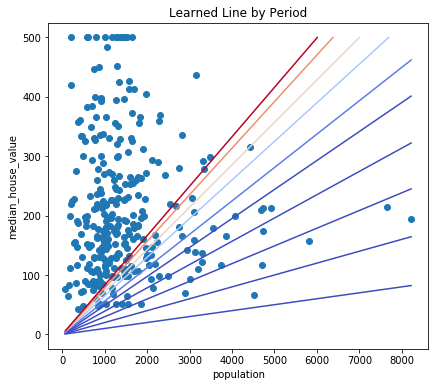

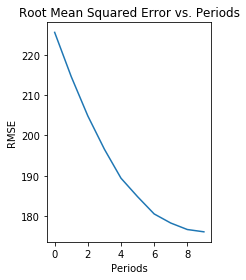

,predictions,targets
count,17000.0,17000.0
mean,118.9,207.3
std,95.5,116.0
min,0.2,15.0
25%,65.7,119.4
50%,97.1,180.4
75%,143.2,265.0
max,2968.8,500.0


Final RMSE (on training data): 176.06


In [27]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)